In [1]:
import math
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
from ecell4 import *

In [2]:
def loadata(fname):
    namelist = os.listdir(fname)
    norun = len(namelist)
    print norun
    ret = np.array([])
    for name in namelist:
        dat = np.loadtxt(fname+name,delimiter=',')   
        ret =  np.r_[ret,dat]
    return ret,norun

In [3]:
def gethist(fname):
    print fname
    ret,norun = loadata(fname)
    print 'total rebinding counts',len(ret)
    meanret = np.mean(ret)
    print 'mean',meanret,'min,max',min(ret),max(ret)
    #print '1/ka',1./12.56
    bmin = math.log10(min(ret)*0.9)
    bmax = math.log10(max(ret))
    bnum = int(bmax-bmin)*10
    binlist = np.logspace(bmin,bmax,bnum)
    hist, bin_edges = np.histogram(ret, bins = binlist)
    binwidth = bin_edges[1:]-bin_edges[:-1]    
    #print binwidth[1:]/binwidth[:-1]
    t = 0.5*(bin_edges[1:]+bin_edges[:-1])
    N = 10000*norun
    prob = [float(h)/N/w for h,w in zip(hist,binwidth)]
    sump = np.sum(prob*binwidth)
    tmol = 1.66666666667e-06
    index = np.where((bin_edges>tmol)==True)[0][0] #first occurence
    sumtiltmol = np.sum((prob*binwidth)[:index-1])
    #print 'sum til tmol',sumtiltmol
    #print (prob*binwidth)[:10]
    #print bin_edges[:10]
    #plt.semilogx(t,np.cumsum(prob*binwidth)/sump,'.',label=fname)
    #plt.legend()
    print 'sum of prob',sump
    return t,prob#t,np.cumsum(prob*binwidth)/sump#

def gethist2(fname): #to get rxn fraction for each discrete t
    ret,norun = loadata(fname)
    uq,uqcnt = np.unique(ret,return_counts=True)
    freq = [float(i)/10000/norun for i in uqcnt]
    #for i,j in zip(uq,uqcnt): print i,j
    plt.loglog(freq,'.')
    #tmol = uq[0]*296.042039057*2 
    #print tmol
    #index = np.argmax(uq>tmol)-1    
    #print freq[:5]
    #print uq[:5]
    #print 'sum',sum(freq[1:index+1])

#gethist("data/fpt_1kD_L1_short/")

data/fpt_01kD_L1/
70
total rebinding counts 63829
mean 0.000167797578948 min,max 1.66666666667e-06 0.024665
sum til tmol 0.0
sum of prob 0.0911828571429
data/fpt_10kD_L1/
70
total rebinding counts 636402
mean 1.69602747263e-05 min,max 5.6298310604e-08 0.025317800665
sum til tmol 0.784311428571
sum of prob 0.909144285714
Ptotal 0.0909090909091 total of numerical integration 0.0893727272727
Ptotal 0.909090909091 total of numerical integration 0.893727272727


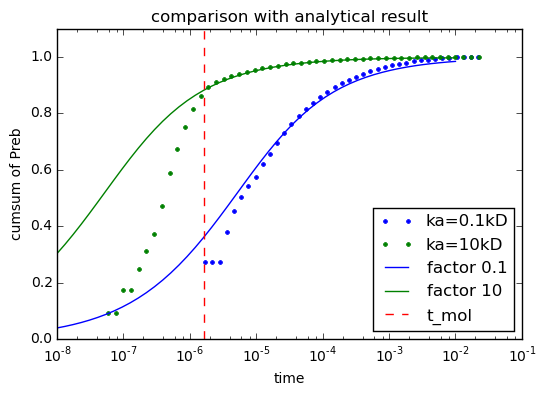

In [514]:
#cumulative sum of Preb
from scipy import integrate
t1,cs1 = gethist("data/fpt_01kD_L1/")
t2,cs2 = gethist("data/fpt_10kD_L1/")
plt.semilogx(t1,cs1,'b.',label='ka=0.1kD')
plt.semilogx(t2,cs2,'g.',label='ka=10kD')

def Pf(t,factor):
    R = 2*0.005
    D = 10.#10.
    kD = 4*3.14*R*D
    ka = factor*kD
    tmol = R*R/D/(1+ka/kD)**2
    Ptotal = ka/(ka+kD)  
    return Ptotal*f(t)
for factor in [0.1,10]:
    R = 2*0.005
    D = 10.#10.
    kD = 4*3.14*R*D
    ka = factor*kD
    tmol = R*R/D/(1+ka/kD)**2
    Ptotal = ka/(ka+kD)  
    print 'Ptotal',Ptotal,'total of numerical integration',0.9831*Ptotal
    time =  np.logspace(-8,-2,50)
    Sum = []
    for t in time:
        tau = t/tmol
        ss = integrate.quad(Pf, 0, tau,args=(factor,))   
        Sum.append(ss[0]/0.983/Ptotal)
    plt.semilogx(time,Sum,'-',label='factor '+str(factor))
tmol = 1.66666666667e-06
prange = np.logspace(-3,8,10)
plt.plot([tmol]*len(prange),prange,'--r',label='t_mol')
plt.title('comparison with analytical result' )
plt.ylim(0,1.1)
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('cumsum of Preb')
#integrate.quad(f, 0, np.inf) 
#plt.savefig("figure/rebinding_prob_run13.png",format='png',dpi=100)    

In [4]:
def create_model_gil(Da,Db,k): 
    with species_attributes():
        A | {'D': str(Da)}
        B | {'D': str(Db)}
    with reaction_rules():
        A + B > B | k
    return get_model()

def ode(time,escapep,L,factor):
    vol = L**3 #spa vol
    Da = 10.
    voxelr = 0.005
    kD = 4*3.14*2*voxelr*Da
    ka = factor*kD
    kon = ka*kD/(ka+kD)
    V = (L*5)**3 #ode sim vol
    conc = 1./vol
    Na = int(V*conc)
    m = create_model_gil(Da,0.0,kon / vol * V)
    Nt = ensemble_simulations(1,time, model=m,y0={'A':Na,'B':1}, solver='ode',volume=V,return_type='observer')
    time = Nt.data()[:,0]
    St = Nt.data()[:,1]/Na * escapep
    Rt = -(St[1:]-St[:-1])/(time[1:]-time[:-1])
    return Rt
    

In [9]:
print 'total Preb for ka = 0.1kD, 0.091'
print 'total Preb for ka = 10kD, 0.91'
t1,prob1 = gethist("data/fpt_01kD_L1/")
#t2,prob2 = gethist("data/fpt_01kD_L5/")
t3,prob3 = gethist("data/fpt_10kD_L1/")
#t4,prob4 = gethist("data/fpt_10kD_L1_noremove/")
#t5,prob5 = gethist("data/fpt_10kD_L015_noremove/")
#t6,prob6 = gethist("data/fpt_10kD_L015/")
#t7,prob7 = gethist("data/fpt_10kD_L015_noremove_1s/")
t8,prob8 = gethist("data/fpt_001kD_L1_short/")
#t9,prob9 = gethist("data/fpt_01kD_L1_short/")
#ta,proba = gethist("data/fpt_10kD_L1_short/")
#tb,probb = gethist("data/fpt_100kD_L1_short/")
tc,probc = gethist("data/fpt_1kD_L1_short/")
#td,probd = gethist("data/fpt_100kD_L1_short_alpha0.1a/")
#te,probe = gethist("data/fpt_100kD_L1_short_rxnaftertmol/")
#tf,probf = gethist("data/fpt_100kD_L1_short_alpha0.01a/")
#tg,probg = gethist("data/fpt_100kD_L1_medium/")

total Preb for ka = 0.1kD, 0.091
total Preb for ka = 10kD, 0.91
data/fpt_01kD_L1/
70
total rebinding counts 63829
mean 0.000167797578948 min,max 1.66666666667e-06 0.024665
sum of prob 0.0911828571429
data/fpt_10kD_L1/
70
total rebinding counts 636402
mean 1.69602747263e-05 min,max 5.6298310604e-08 0.025317800665
sum of prob 0.909144285714
data/fpt_001kD_L1_short/
900
total rebinding counts 75705
mean 1.48720472008e-05 min,max 1.66666666667e-06 0.000101666666667
sum of prob 0.00841166666667
data/fpt_1kD_L1_short/
70
total rebinding counts 322819
mean 8.74040693866e-06 min,max 5.6298310604e-07 0.000100210992875
sum of prob 0.46117


In [10]:
def phix(x):
    return 1./( (377.*x/324)+(1+ (314.*(x**2)/847) )**0.5)

def f(t):
    x = np.sqrt(t)
    return (1./math.pi**0.5 /x - phix(x))

def theory(factor,c):
    R = 2*0.005
    D = 10.
    kD = 4*3.14*R*D
    ka = factor*kD
    print ka
    tmol = R*R/D/(1+ka/kD)**2
    Ptotal = ka/(ka+kD)
    print 'tmol',tmol
    print 'ka,kD,Ptotal',ka,kD,Ptotal
    tau = np.logspace(-5,math.log10(1e-1/tmol),100)
    #tau = np.logspace(0,math.log10(1e-1/tmol),100)
    t = tau*tmol
    Nfactor = (ka*(1+ka/kD)*D/kD/R/R)
    plt.loglog(t,f(tau)*Nfactor,'-',c=c)#,label='factor'+str(factor))
    plt.legend()
    #plt.plot([tmol]*10, np.logspace(-10,4,10),'--')
    return #t,Ptotal*f(tau)

def apptheory(factor,P,step):
    R = 2*0.005
    D = 10.
    kD = 4*3.14*R*D
    ka = factor*kD
    tmol = R*R/D/(1+ka/kD)**2    
    Nfactor = (ka*(1+ka/kD)*D/kD/R/R)    
    dt = 2*0.005*0.005/3./D
    Pa = ka/6./(2**0.5)/D/0.005
    alpha = P/Pa
    tstep = dt*alpha
    tt = np.arange(tstep,10*dt,tstep)
    yy = Nfactor/(tt/tmol)**1.5
    prob = -(yy[1:]-yy[:-1])*(tt[1:])
    #print (tt[1:]-tt[:-1])
    #plt.loglog(tt,yy,'r-',label='factor'+str(factor))  
    return prob[step]
apptheory(100,1,10)

0.016627841606508126

0.01256
tmol 9.80296049407e-06
ka,kD,Ptotal 0.01256 1.256 0.00990099009901
0.1256
tmol 8.26446280992e-06
ka,kD,Ptotal 0.1256 1.256 0.0909090909091
1.256
tmol 2.5e-06
ka,kD,Ptotal 1.256 1.256 0.5
12.56
tmol 8.26446280992e-08
ka,kD,Ptotal 12.56 1.256 0.909090909091


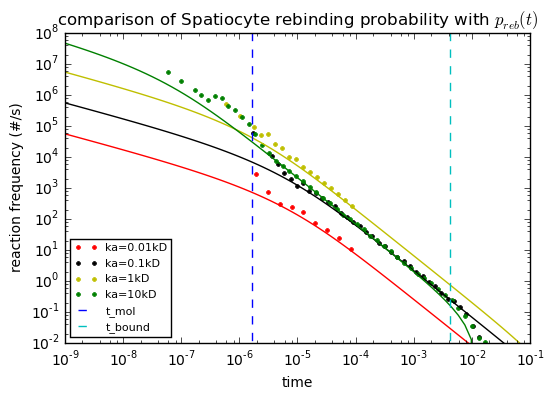

In [19]:
plt.plot(t8,prob8,'r.',label='ka=0.01kD')#_L=1_short')
plt.plot(t1,prob1,'k.',label='ka=0.1kD')#_L=1')
#plt.loglog(t2,prob2,'g-',label='ka=0.1kD_L=5')
#plt.plot(t4,prob4,'c.',label='ka=10kD_L=1_noremove')
#plt.plot(t4[1:],ode(t4,0.0607,1.,10),'k-',label='ode, kon')
#plt.loglog(t5,prob5,'y.',label='ka=10kD_L=0.15_noremove')
#plt.loglog(t6,prob6,'b-',label='ka=10kD_L=0.15')
#plt.loglog(t7,prob7,'r.',label='ka=10kD_L=0.15_1s_noremove')
#plt.plot(t7[1:],ode(t7,0.095,0.15,10),'-',label='ode')
#plt.plot(t9,prob9,'.',label='ka=0.1kD_L=1_short')
plt.plot(tc,probc,'y.',label='ka=1kD')#_L=1_short')
plt.plot(t3,prob3,'g.',label='ka=10kD')#_L=1')
#plt.plot(ta,proba,'y.',label='ka=10kD_L=1_short')
#plt.plot(tb,probb,'b.',label='ka=100kD_L=1_short_alpha=1/Pa')
#plt.plot(tg,probg,'g.',label='ka=100kD_L=1_medium')
#plt.plot(td,probd,'r.',label='ka=100kD_L=1_short_alpha=0.1/Pa')
#plt.plot(tf,probf,'g.',label='ka=100kD_L=1_short_alpha=0.01/Pa')
#plt.plot(te,probe,'r.',label='ka=100kD_L=1_short_no rxn till tmol')
clr = ['r','k','y','g','b']
i=0
for ff in [0.01,0.1,1.,10]:
    c= clr[i] 
    theory(ff,c)
    i+=1
i = 0
for ff in [10]:
    c = clr[i]
    i +=1
    #for P in [1]:
        #tt,rps = rxp(ff,P)
        #plotg(tt,rps)     
        
#z = lambda x: 1e-4*(x**-0.5) #t^(-0.5)
#tt = np.logspace(-10,-6,100)
#K = 1e7#125.6
#kexp = lambda x: K*np.exp(-K*x)
#plt.plot(tt,kexp(tt),'c-')
tt2 = np.logspace(-7,-2,100)
y = lambda x: 1e-3*(x**(-3./2)) #t^(-3/2)
#plt.plot(tt2,y(tt2),label='p ~ t^(-3/2)')

#plt.plot(tt2,z(tt2),label='p ~ t^-0.5')
tmol = 1.66666666667e-06
tbound = 0.00416666666667 #L=1
tbound2 = 9.375e-05 #L=0.15
prange = np.logspace(-3,8,10)
plt.plot([tmol]*len(prange),prange,'--b',label='t_mol')
plt.plot([tbound]*len(prange),prange,'--c',label='t_bound')
#plt.plot([tbound2]*len(prange),prange,'g')
plt.ylabel('reaction frequency (#/s)')
plt.xlabel('time')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2,1e8)
plt.xlim(1e-9,1e-1)
plt.title('comparison of Spatiocyte rebinding probability with $p_{reb}(t)$')
plt.legend(loc='best',fontsize=8)
plt.savefig("figure/rebinding_prob_forPoster.png",format='png',dpi=100)    

In [91]:
def rxp(factor,P):
    Da = 10.
    voxelr = 0.005
    kD = 4*3.14*2*voxelr*Da
    ka = factor*kD
    Pa = ka/6./(2**0.5)/Da/voxelr
    dt = 2*voxelr*voxelr/3./Da
    #P = 1.
    alpha = P/Pa
    tstep = dt*alpha
    taumol = voxelr*voxelr/Da/(1+ka/kD)**2
    #print 'alpha,tmol,tmolnew,taumol',alpha,dt,tstep,taumol
    rp0 = Pa*alpha/12
    print 'Pa',Pa,alpha,tstep,dt
    pe = 11*alpha/12
    tsteps = [tstep]
    time = tstep
    rp = rp0
    pw4 = alpha*4./12
    N = 1.
    #Nfactor = (taumol**1.5)*(ka*(1+ka/kD)*Da/kD/voxelr/voxelr)
    fac2 = voxelr*voxelr/6/Da#/taumol
    rps = [rp0]
    while time < 1*dt:
        #rp = rp0*((pw4+(1-rp0))**(N-1)) #no return to in-contact voxel
        #pre = apptheory(factor,P,int(N-1))
        rp = rp0*((pw4+(1-rp0))**(N-1))#return of non-in-contact
        #rp = rp0*(1-rp) #no escape from original voxel
        rps.append(rp)
        #print rp,tstep
        time += tstep
        N +=1
        tsteps.append(time)
    #rps = [1./12,1./36,11./576,11./864,299./31104]        
    #tsteps = np.arange(dt,len(rps),dt)    
    print 'factor',ff
    Ptotal = ka/(ka+kD)
    print 'analytical total rebinding prob',Ptotal
    print 'sum of prob, ratio',sum(rps),sum(rps)/Ptotal
    return tsteps,rps

def plotg(tt,rps):
    rps = np.array(rps)
    bmin = math.log10(min(tt)*0.9)
    bmax = math.log10(max(tt))
    bnum = int((bmax-bmin)*10)
    binlist = np.logspace(bmin,bmax,bnum)
    width = []
    mid = []
    tt = np.array(tt)
    prob = []
    for j in range(len(binlist)-1):
        index = np.where(((tt>binlist[j]) *(tt<=binlist[j+1]))==True)
        if (len(index[0])!=0):
            width = binlist[j+1]-binlist[j]
            mid.append(0.5*(binlist[j+1]+binlist[j]))
            prob.append(sum(rps[index])/width)
    
    #for t in tt:
    #    for j in range(len(binlist)):
    #        if (binlist[j]<t and t<=binlist[j+1]):
    #            w = binlist[j+1]-binlist[j]
    #            mid.append(0.5*(binlist[j+1]+binlist[j]))
    #            width.append(w)
    #width = np.array(width)
    #print width[1:]/width[:-1]
    #rps = np.array(rps)/width
    #plt.loglog(mid,rps,'.')
    plt.loglog(mid,prob,'.-')
    


Pa 0.0296042039057 33.7789863624 5.6298310604e-05 1.66666666667e-06
factor 0.01
analytical total rebinding prob 0.00990099009901
sum of prob, ratio 0.0833333333333 8.41666666667


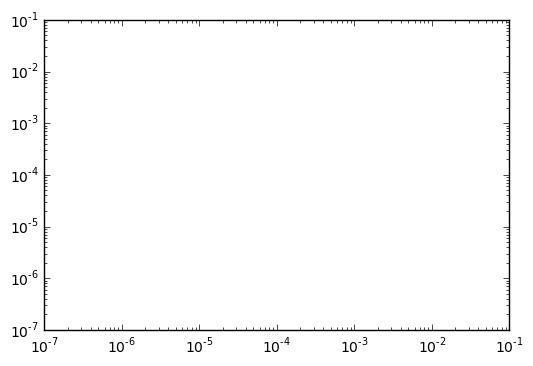

In [100]:
for ff in [0.01]:
    for P in [1]:
        tt,rps = rxp(ff,P)   
        
        plotg(tt,rps)

In [363]:
[1./(n+1) for n in range(100)][-1]

0.01

In [29]:
np.arange(0,5,1)

array([0, 1, 2, 3, 4])

In [67]:
alpha = 1./296
alpha

0.0033783783783783786